## 환경 설정 및 라이브러리 임포트

In [1]:
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle, FancyBboxPatch
import warnings
warnings.filterwarnings('ignore')
# Set Korean font
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# Set style
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")

### Load data from optimization_comparison_results.xlsx

In [2]:
def load_data_from_excel():
    file_path = '../optimization_comparison_results.xlsx'
    df_raw = pd.read_excel(file_path, sheet_name='Raw Results')
    
    algorithms = ['NSGA-II', 'NSGA-III', 'SPEA2', 'ε-MOEA']
    metrics_data = {
        'HYPERVOLUME': {},
        'SPACING': {},
        'DIVERSITY': {},
        'CONVERGENCE': {},
        'EXECUTION_TIME': {}
    }
    
    # Row ranges for each metric
    row_ranges = {
        'HYPERVOLUME': [1, 2, 3, 4],
        'SPACING': [8, 9, 10, 11],
        'DIVERSITY': [15, 16, 17, 18],
        'CONVERGENCE': [22, 23, 24, 25],
        'EXECUTION_TIME': [29, 30, 31, 32]
    }
    
    for metric, rows in row_ranges.items():
        for idx in rows:
            row = df_raw.iloc[idx]
            algo = str(row['HYPERVOLUME']).strip()
            if algo in algorithms:
                values = []
                for col in df_raw.columns[1:11]:
                    val = row[col]
                    if pd.notna(val):
                        try:
                            values.append(float(val))
                        except:
                            pass
                metrics_data[metric][algo] = values
    
    return algorithms, metrics_data

ALGORITHMS, DATA = load_data_from_excel()

## Figure 1: Performance Radar Chart

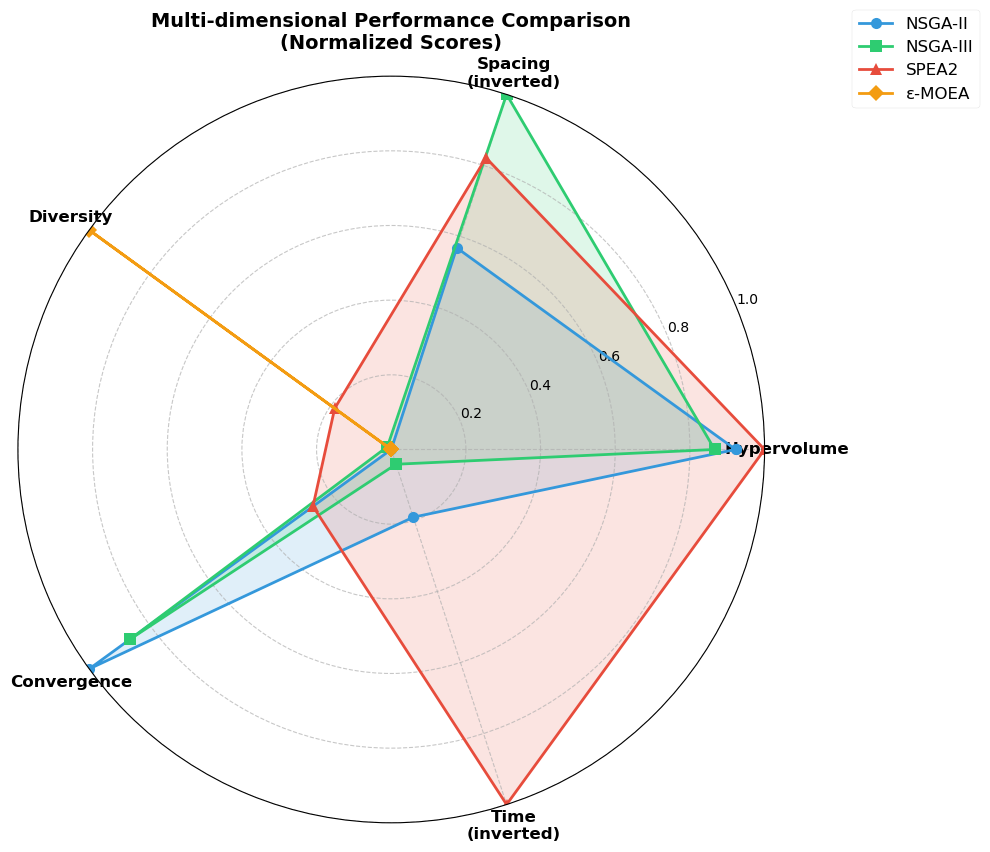

In [3]:
# Normalize data
metrics = ['Hypervolume', 'Spacing\n(inverted)', 'Diversity', 'Convergence', 'Time\n(inverted)']

hypervolume = np.array([np.mean(DATA['HYPERVOLUME'][algo]) for algo in ALGORITHMS])
spacing = np.array([np.mean(DATA['SPACING'][algo]) for algo in ALGORITHMS])
diversity = np.array([np.mean(DATA['DIVERSITY'][algo]) for algo in ALGORITHMS])
convergence = np.array([np.mean(DATA['CONVERGENCE'][algo]) for algo in ALGORITHMS])
time = np.array([np.mean(DATA['EXECUTION_TIME'][algo]) for algo in ALGORITHMS])

def normalize(values, invert=False):
    if invert:
        values = 1.0 / (values + 0.001)
    normalized = (values - values.min()) / (values.max() - values.min() + 1e-10)
    return normalized

data_matrix = np.array([
    normalize(hypervolume),
    normalize(spacing, invert=True),  # Lower is better
    normalize(diversity),
    normalize(convergence, invert=True),  # Lower is better
    normalize(time, invert=True)  # Lower is better
]).T

# Radar chart
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
data_matrix = np.concatenate((data_matrix, data_matrix[:, [0]]), axis=1)
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
markers = ['o', 's', '^', 'D']

for i, (algo, color, marker) in enumerate(zip(ALGORITHMS, colors, markers)):
    ax.plot(angles, data_matrix[i], 'o-', linewidth=2, color=color, 
            label=algo, marker=marker, markersize=8)
    ax.fill(angles, data_matrix[i], alpha=0.15, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, size=12, weight='bold')
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=10)
ax.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12)
plt.title('Multi-dimensional Performance Comparison\n(Normalized Scores)', 
            size=14, weight='bold', pad=20)

plt.tight_layout()
plt.savefig(f'../../result/figures/figure1_radar_chart.png', dpi=300, bbox_inches='tight')

## Figure 2: Hypervolume Distribution Box Plots

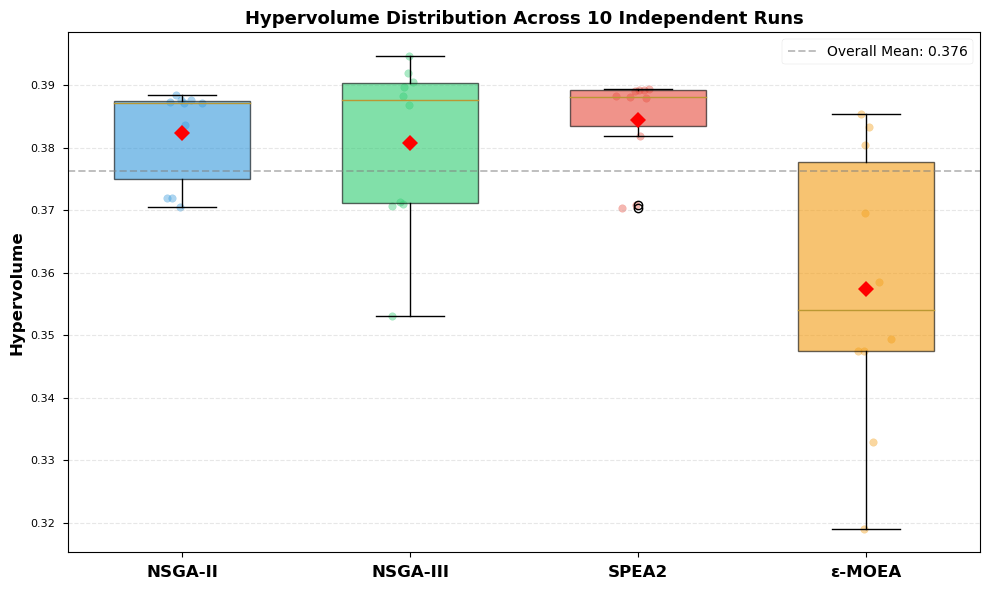

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data
data_list = [DATA['HYPERVOLUME'][algo] for algo in ALGORITHMS]
positions = np.arange(len(ALGORITHMS))

# Create box plots
bp = ax.boxplot(data_list, positions=positions, widths=0.6,
                patch_artist=True, showmeans=True,
                meanprops=dict(marker='D', markerfacecolor='red', 
                                markeredgecolor='red', markersize=8))

# Color boxes
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

# Add individual points
for i, data in enumerate(data_list):
    y = data
    x = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x, y, alpha=0.4, s=30, color=colors[i])

# Formatting
ax.set_xticks(positions)
ax.set_xticklabels(ALGORITHMS, fontsize=12, weight='bold')
ax.set_ylabel('Hypervolume', fontsize=12, weight='bold')
ax.set_title('Hypervolume Distribution Across 10 Independent Runs', 
            fontsize=13, weight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add overall mean line
overall_mean = np.mean([np.mean(d) for d in data_list])
ax.axhline(overall_mean, color='gray', linestyle='--', alpha=0.5, 
            label=f'Overall Mean: {overall_mean:.3f}')
ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig('../../result/figures/figure2_hypervolume_boxplots.png', dpi=300, bbox_inches='tight')

## Figure 3: Spacing Comparison Bar Chart

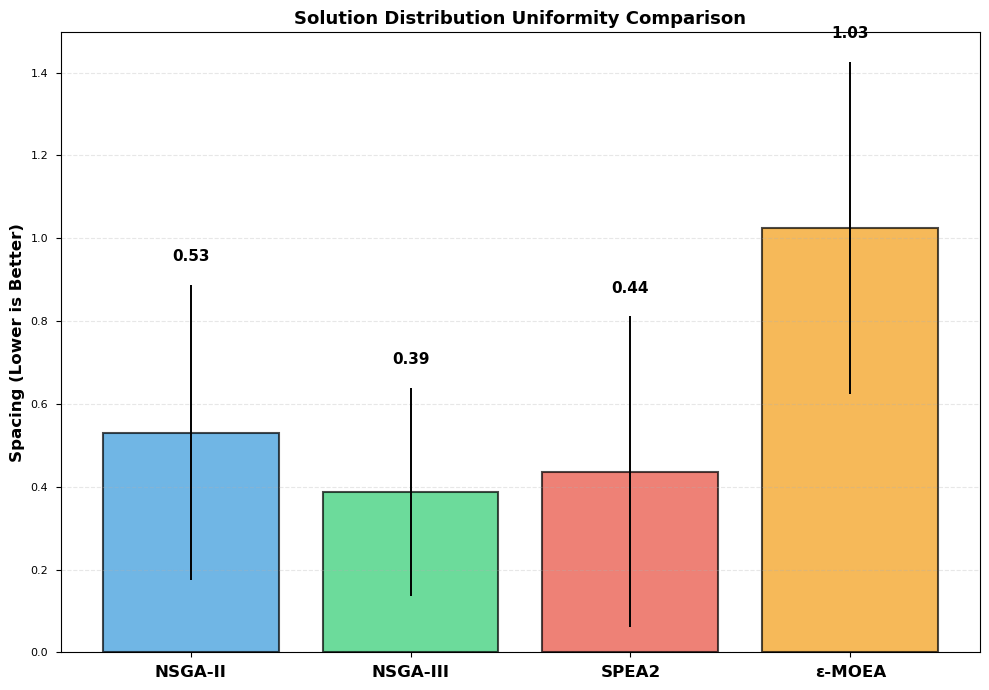

In [5]:
fig, ax = plt.subplots(figsize=(10, 7))

means = [np.mean(DATA['SPACING'][algo]) for algo in ALGORITHMS]
stds = [np.std(DATA['SPACING'][algo]) for algo in ALGORITHMS]

x = np.arange(len(ALGORITHMS))
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

bars = ax.bar(x, means, yerr=stds, capsize=5, alpha=0.7, 
                color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (mean, std) in enumerate(zip(means, stds)):
    ax.text(i, mean + std + 0.05, f'{mean:.2f}', 
            ha='center', va='bottom', fontsize=11, weight='bold')

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(ALGORITHMS, fontsize=12, weight='bold')
ax.set_ylabel('Spacing (Lower is Better)', fontsize=12, weight='bold')
ax.set_title('Solution Distribution Uniformity Comparison', 
            fontsize=13, weight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('../../result/figures/figure3_spacing_comparison.png', dpi=300, bbox_inches='tight')

## Figure 4: Diversity vs Convergence Scatter Plot

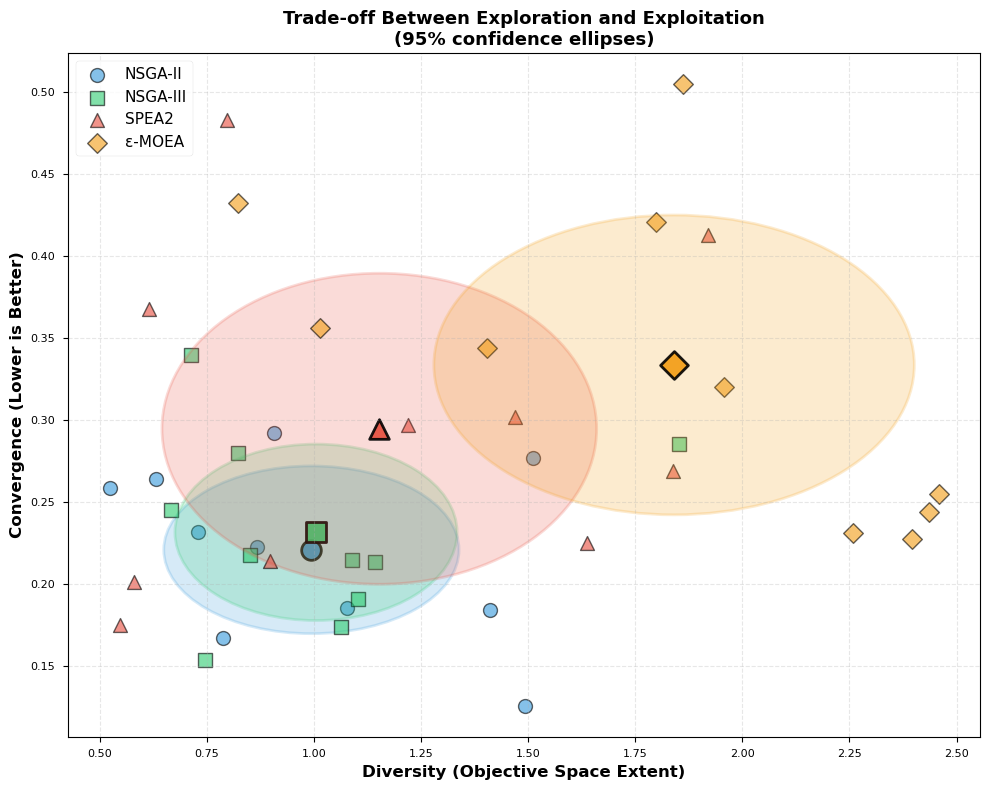

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
markers = ['o', 's', '^', 'D']

for i, (algo, color, marker) in enumerate(zip(ALGORITHMS, colors, markers)):
    diversity_runs = DATA['DIVERSITY'][algo]
    convergence_runs = DATA['CONVERGENCE'][algo]
    
    # Scatter points
    ax.scatter(diversity_runs, convergence_runs, s=100, alpha=0.6,
                color=color, marker=marker, edgecolors='black', linewidth=1,
                label=algo)
    
    # Add 95% confidence ellipse
    from matplotlib.patches import Ellipse
    mean_div = np.mean(diversity_runs)
    mean_conv = np.mean(convergence_runs)
    std_div = np.std(diversity_runs)
    std_conv = np.std(convergence_runs)
    
    ellipse = Ellipse((mean_div, mean_conv), width=2*std_div, height=2*std_conv,
                        alpha=0.2, facecolor=color, edgecolor=color, linewidth=2)
    ax.add_patch(ellipse)
    
    # Add mean marker
    ax.scatter(mean_div, mean_conv, s=200, alpha=0.9, color=color,
                marker=marker, edgecolors='black', linewidth=2)

# Formatting
ax.set_xlabel('Diversity (Objective Space Extent)', fontsize=12, weight='bold')
ax.set_ylabel('Convergence (Lower is Better)', fontsize=12, weight='bold')
ax.set_title('Trade-off Between Exploration and Exploitation\n(95% confidence ellipses)', 
            fontsize=13, weight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=11, loc='upper left')

plt.tight_layout()
plt.savefig('../../result/figures/figure4_diversity_convergence.png', dpi=300, bbox_inches='tight')

## Figure 5: Execution Time Comparison

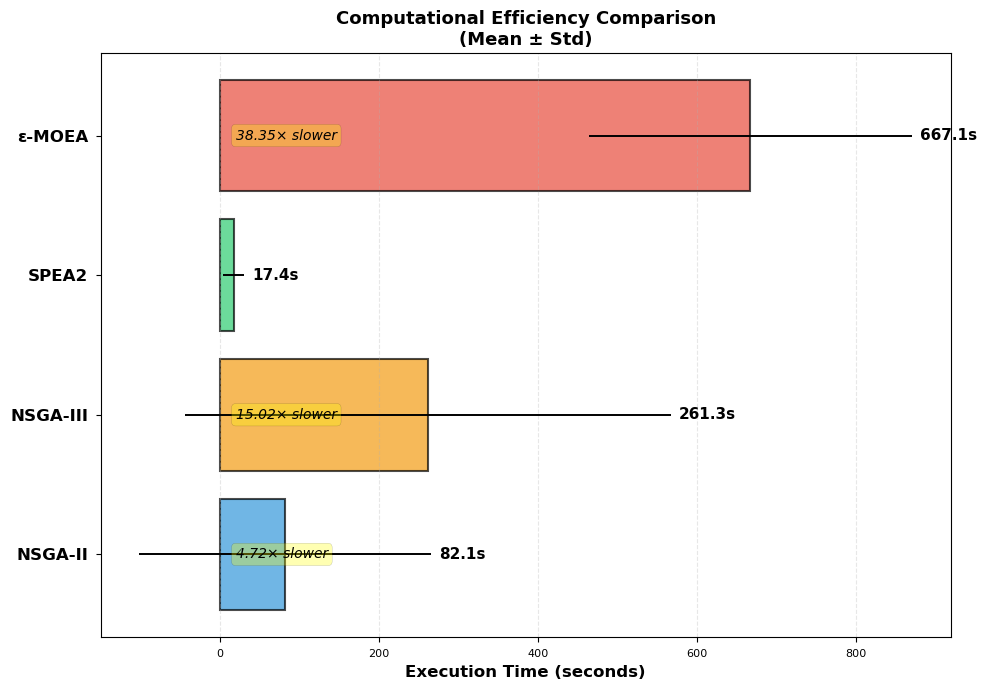

In [7]:
fig, ax = plt.subplots(figsize=(10, 7))

means = np.array([np.mean(DATA['EXECUTION_TIME'][algo]) for algo in ALGORITHMS])
stds = np.array([np.std(DATA['EXECUTION_TIME'][algo]) for algo in ALGORITHMS])

x = np.arange(len(ALGORITHMS))
colors = ['#3498db', '#f39c12', '#2ecc71', '#e74c3c']

bars = ax.barh(x, means, xerr=stds, capsize=5, alpha=0.7,
                color=colors, edgecolor='black', linewidth=1.5)

# Add value labels
for i, (mean, std) in enumerate(zip(means, stds)):
    ax.text(mean + std + 10, i, f'{mean:.1f}s', 
            va='center', fontsize=11, weight='bold')

# Add speedup factors
fastest_idx = np.argmin(means)
fastest = means[fastest_idx]
speedups = means / fastest
for i, speedup in enumerate(speedups):
    if i != fastest_idx:
        ax.text(20, i, f'{speedup:.2f}× slower', 
                va='center', fontsize=10, style='italic',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

# Formatting
ax.set_yticks(x)
ax.set_yticklabels(ALGORITHMS, fontsize=12, weight='bold')
ax.set_xlabel('Execution Time (seconds)', fontsize=12, weight='bold')
ax.set_title('Computational Efficiency Comparison\n(Mean ± Std)', 
            fontsize=13, weight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('../../result/figures/figure5_execution_time.png', dpi=300, bbox_inches='tight')

## Table 1: Performance Summary Table Visualization

In [14]:
# Prepare data
metrics = ['HYPERVOLUME', 'SPACING', 'DIVERSITY', 'CONVERGENCE', 'EXECUTION_TIME']
metric_labels = ['Hypervolume', 'Spacing', 'Diversity', 'Convergence', 'Time (sec)']

table_data = []
table_data.append(['Metric'] + ALGORITHMS)

for metric, label in zip(metrics, metric_labels):
    row = [label]
    for algo in ALGORITHMS:
        mean = np.mean(DATA[metric][algo])
        std = np.std(DATA[metric][algo])
        if metric == 'EXECUTION_TIME':
            row.append(f'{mean:.1f}±{std:.1f}')
        else:
            row.append(f'{mean:.3f}±{std:.3f}')
    table_data.append(row)

df = pd.DataFrame(table_data[1:], columns=table_data[0])
df = df.set_index('Metric')
df.to_excel('../../result/tables/Table1.xlsx', engine='openpyxl')

## Create a comprehensive comparison figure

Text(0.5, 0.995, '📊 다목적 최적화 성능 지표 비교 시각화 (METOR 프로젝트)')

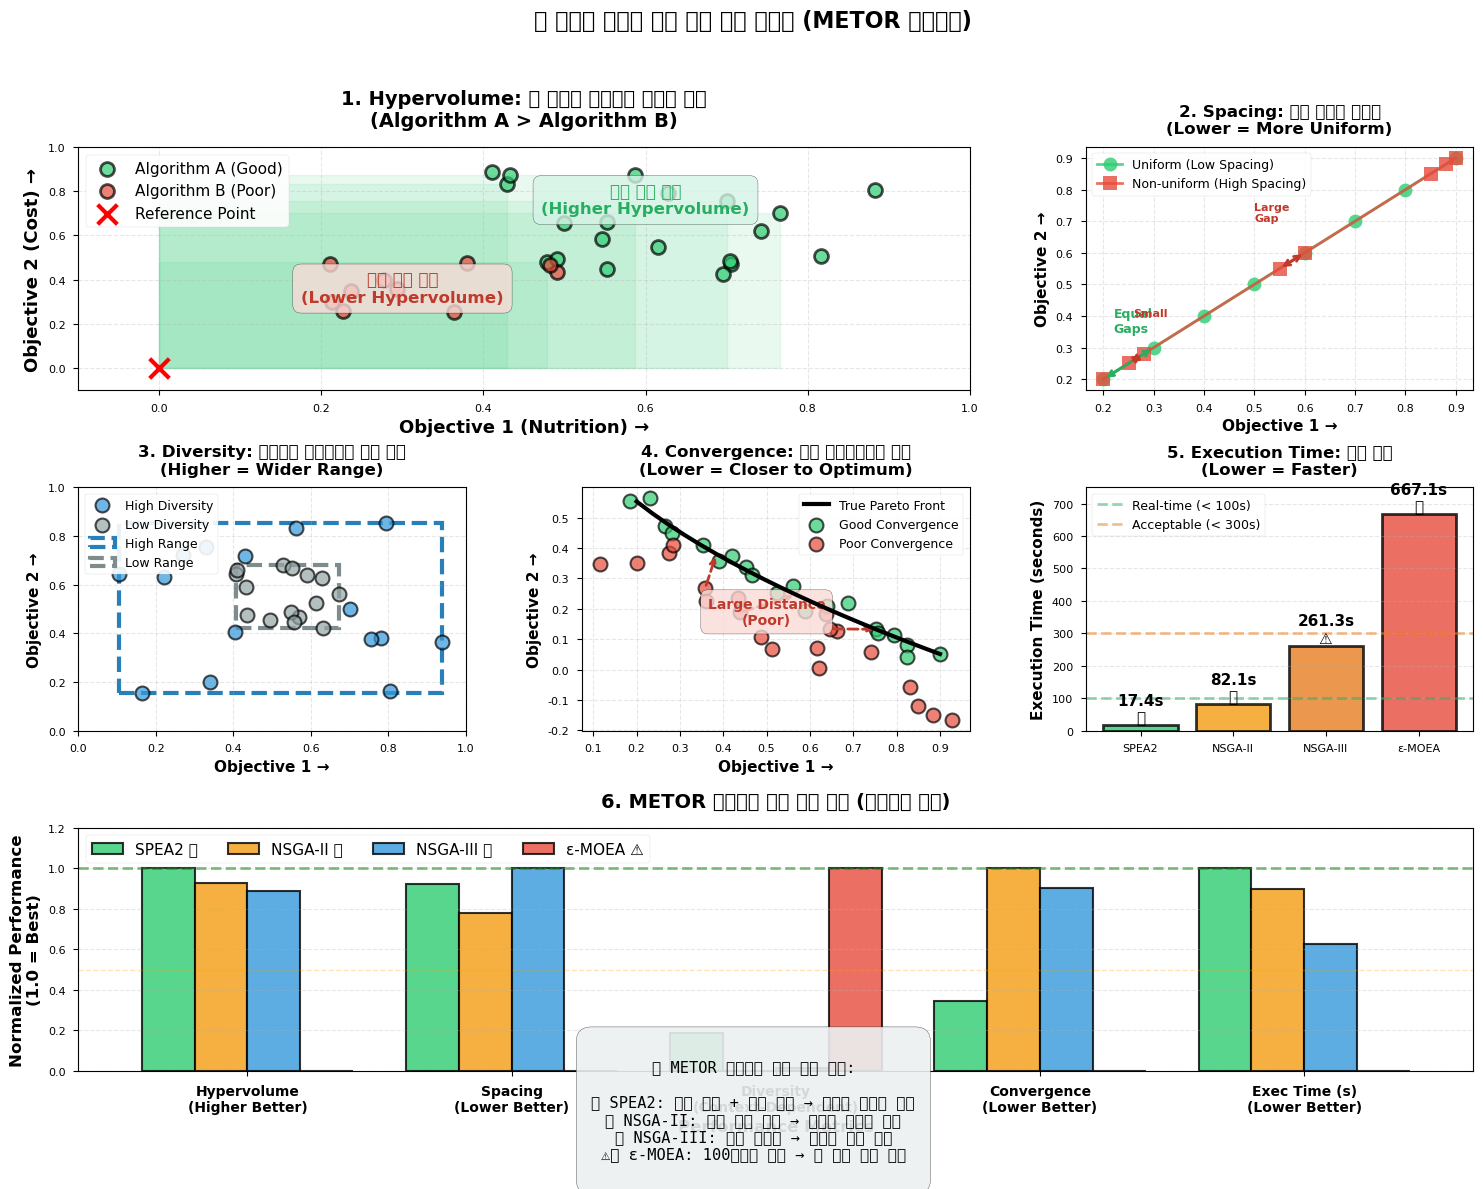

In [9]:
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.3)

# ========== 1. HYPERVOLUME COMPARISON ==========
ax1 = fig.add_subplot(gs[0, :2])

# Create two solution sets
np.random.seed(42)
good_solutions = np.random.rand(20, 2) * 0.5 + 0.4  # High quality, well distributed
bad_solutions = np.random.rand(10, 2) * 0.3 + 0.2   # Lower quality, sparse

# Reference point
ref_point = [0, 0]

# Plot
ax1.scatter(good_solutions[:, 0], good_solutions[:, 1], 
           s=100, c='#2ecc71', alpha=0.7, edgecolors='black', linewidth=2,
           label='Algorithm A (Good)', zorder=3)
ax1.scatter(bad_solutions[:, 0], bad_solutions[:, 1], 
           s=100, c='#e74c3c', alpha=0.7, edgecolors='black', linewidth=2,
           label='Algorithm B (Poor)', zorder=3)

# Draw hypervolume regions
for sol in good_solutions[:5]:  # Show a few examples
    width = sol[0] - ref_point[0]
    height = sol[1] - ref_point[1]
    rect = Rectangle(ref_point, width, height, 
                    linewidth=1, edgecolor='#2ecc71', 
                    facecolor='#2ecc71', alpha=0.1)
    ax1.add_patch(rect)

ax1.scatter([0], [0], s=200, c='red', marker='x', linewidth=3, 
           label='Reference Point', zorder=4)
ax1.set_xlabel('Objective 1 (Nutrition) →', fontsize=13, fontweight='bold')
ax1.set_ylabel('Objective 2 (Cost) →', fontsize=13, fontweight='bold')
ax1.set_title('1. Hypervolume: 해 집합이 지배하는 공간의 부피\n(Algorithm A > Algorithm B)', 
             fontsize=14, fontweight='bold', pad=15)
ax1.legend(loc='upper left', fontsize=11, framealpha=0.9)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_xlim(-0.1, 1.0)
ax1.set_ylim(-0.1, 1.0)

# Add annotations
ax1.annotate('넓은 영역 커버\n(Higher Hypervolume)', 
            xy=(0.6, 0.7), fontsize=12, color='#27ae60',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='#d5f4e6', alpha=0.8),
            ha='center', fontweight='bold')
ax1.annotate('좁은 영역 커버\n(Lower Hypervolume)', 
            xy=(0.3, 0.3), fontsize=12, color='#c0392b',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='#fadbd8', alpha=0.8),
            ha='center', fontweight='bold')

# ========== 2. SPACING COMPARISON ==========
ax2 = fig.add_subplot(gs[0, 2])

# Create uniform and non-uniform distributions
uniform_x = np.linspace(0.2, 0.9, 8)
uniform_y = np.linspace(0.2, 0.9, 8)

non_uniform_x = np.array([0.2, 0.25, 0.28, 0.55, 0.60, 0.85, 0.88, 0.90])
non_uniform_y = np.array([0.2, 0.25, 0.28, 0.55, 0.60, 0.85, 0.88, 0.90])

# Plot uniform
ax2.plot(uniform_x, uniform_y, 'o-', color='#2ecc71', 
        markersize=10, linewidth=2, label='Uniform (Low Spacing)', alpha=0.8)
ax2.plot(non_uniform_x, non_uniform_y, 's-', color='#e74c3c', 
        markersize=10, linewidth=2, label='Non-uniform (High Spacing)', alpha=0.8)

ax2.set_xlabel('Objective 1 →', fontsize=11, fontweight='bold')
ax2.set_ylabel('Objective 2 →', fontsize=11, fontweight='bold')
ax2.set_title('2. Spacing: 해들 간격의 균일성\n(Lower = More Uniform)', 
             fontsize=12, fontweight='bold', pad=10)
ax2.legend(loc='upper left', fontsize=9, framealpha=0.9)
ax2.grid(True, alpha=0.3, linestyle='--')

# Add distance annotations
ax2.annotate('', xy=(uniform_x[1], uniform_y[1]), xytext=(uniform_x[0], uniform_y[0]),
            arrowprops=dict(arrowstyle='<->', color='#27ae60', lw=2))
ax2.text(0.22, 0.35, 'Equal\nGaps', fontsize=9, color='#27ae60', fontweight='bold')

ax2.annotate('', xy=(non_uniform_x[2], non_uniform_y[2]), xytext=(non_uniform_x[1], non_uniform_y[1]),
            arrowprops=dict(arrowstyle='<->', color='#c0392b', lw=2))
ax2.text(0.26, 0.40, 'Small', fontsize=8, color='#c0392b', fontweight='bold')

ax2.annotate('', xy=(non_uniform_x[4], non_uniform_y[4]), xytext=(non_uniform_x[3], non_uniform_y[3]),
            arrowprops=dict(arrowstyle='<->', color='#c0392b', lw=2))
ax2.text(0.50, 0.70, 'Large\nGap', fontsize=8, color='#c0392b', fontweight='bold')

# ========== 3. DIVERSITY COMPARISON ==========
ax3 = fig.add_subplot(gs[1, 0])

# High diversity
high_div_x = np.random.uniform(0.1, 0.95, 15)
high_div_y = np.random.uniform(0.1, 0.95, 15)

# Low diversity
low_div_x = np.random.uniform(0.4, 0.7, 15)
low_div_y = np.random.uniform(0.4, 0.7, 15)

ax3.scatter(high_div_x, high_div_y, s=100, c='#3498db', 
           alpha=0.7, edgecolors='black', linewidth=1.5,
           label='High Diversity', zorder=3)
ax3.scatter(low_div_x, low_div_y, s=100, c='#95a5a6', 
           alpha=0.7, edgecolors='black', linewidth=1.5,
           label='Low Diversity', zorder=3)

# Draw extent rectangles
high_extent = Rectangle((min(high_div_x), min(high_div_y)), 
                        max(high_div_x) - min(high_div_x), 
                        max(high_div_y) - min(high_div_y),
                        linewidth=3, edgecolor='#2980b9', 
                        facecolor='none', linestyle='--', label='High Range')
low_extent = Rectangle((min(low_div_x), min(low_div_y)), 
                       max(low_div_x) - min(low_div_x), 
                       max(low_div_y) - min(low_div_y),
                       linewidth=3, edgecolor='#7f8c8d', 
                       facecolor='none', linestyle='--', label='Low Range')
ax3.add_patch(high_extent)
ax3.add_patch(low_extent)

ax3.set_xlabel('Objective 1 →', fontsize=11, fontweight='bold')
ax3.set_ylabel('Objective 2 →', fontsize=11, fontweight='bold')
ax3.set_title('3. Diversity: 목적함수 공간에서의 탐색 범위\n(Higher = Wider Range)', 
             fontsize=12, fontweight='bold', pad=10)
ax3.legend(loc='upper left', fontsize=9, framealpha=0.9)
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)

# ========== 4. CONVERGENCE COMPARISON ==========
ax4 = fig.add_subplot(gs[1, 1])

# True Pareto front
true_front_x = np.linspace(0.2, 0.9, 20)
true_front_y = 1.0 - true_front_x**0.5

# Good convergence
good_conv_x = true_front_x + np.random.normal(0, 0.02, 20)
good_conv_y = true_front_y + np.random.normal(0, 0.02, 20)

# Poor convergence
poor_conv_x = true_front_x + np.random.normal(0, 0.08, 20)
poor_conv_y = true_front_y + np.random.normal(-0.15, 0.08, 20)

ax4.plot(true_front_x, true_front_y, 'k-', linewidth=3, 
        label='True Pareto Front', zorder=4)
ax4.scatter(good_conv_x, good_conv_y, s=100, c='#2ecc71', 
           alpha=0.7, edgecolors='black', linewidth=1.5,
           label='Good Convergence', zorder=3)
ax4.scatter(poor_conv_x, poor_conv_y, s=100, c='#e74c3c', 
           alpha=0.7, edgecolors='black', linewidth=1.5,
           label='Poor Convergence', zorder=3)

# Draw distance arrows
for i in [5, 10, 15]:
    ax4.annotate('', xy=(true_front_x[i], true_front_y[i]), 
                xytext=(poor_conv_x[i], poor_conv_y[i]),
                arrowprops=dict(arrowstyle='->', color='#c0392b', 
                              lw=2, linestyle='--'))

ax4.set_xlabel('Objective 1 →', fontsize=11, fontweight='bold')
ax4.set_ylabel('Objective 2 →', fontsize=11, fontweight='bold')
ax4.set_title('4. Convergence: 진짜 최적해까지의 거리\n(Lower = Closer to Optimum)', 
             fontsize=12, fontweight='bold', pad=10)
ax4.legend(loc='upper right', fontsize=9, framealpha=0.9)
ax4.grid(True, alpha=0.3, linestyle='--')

ax4.text(0.5, 0.15, 'Large Distance\n(Poor)', fontsize=10, 
        color='#c0392b', ha='center', fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='#fadbd8', alpha=0.8))

# ========== 5. EXECUTION TIME COMPARISON ==========
ax5 = fig.add_subplot(gs[1, 2])

algorithms = ['SPEA2', 'NSGA-II', 'NSGA-III', 'ε-MOEA']
times = [17.4, 82.1, 261.3, 667.1]
colors = ['#2ecc71', '#f39c12', '#e67e22', '#e74c3c']

bars = ax5.bar(algorithms, times, color=colors, edgecolor='black', linewidth=2, alpha=0.8)

# Add value labels
for i, (bar, time) in enumerate(zip(bars, times)):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{time:.1f}s\n{"✅" if time < 100 else "⚠️" if time < 400 else "❌"}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax5.set_ylabel('Execution Time (seconds)', fontsize=11, fontweight='bold')
ax5.set_title('5. Execution Time: 실행 시간\n(Lower = Faster)', 
             fontsize=12, fontweight='bold', pad=10)
ax5.grid(True, axis='y', alpha=0.3, linestyle='--')
ax5.set_ylim(0, 750)

# Add horizontal lines for reference
ax5.axhline(y=100, color='#27ae60', linestyle='--', linewidth=2, alpha=0.5, label='Real-time (< 100s)')
ax5.axhline(y=300, color='#e67e22', linestyle='--', linewidth=2, alpha=0.5, label='Acceptable (< 300s)')
ax5.legend(loc='upper left', fontsize=9, framealpha=0.9)

# ========== 6. METOR RESULTS COMPARISON ==========
ax6 = fig.add_subplot(gs[2, :])

# Data from METOR results
metrics = ['Hypervolume\n(Higher Better)', 'Spacing\n(Lower Better)', 
           'Diversity\n(Context-Dependent)', 'Convergence\n(Lower Better)', 
           'Exec Time (s)\n(Lower Better)']

spea2_scores = [0.384, 0.436, 1.153, 0.295, 17.4]
nsgaii_scores = [0.382, 0.530, 0.994, 0.221, 82.1]
nsgaiii_scores = [0.381, 0.388, 1.005, 0.232, 261.3]
emoea_scores = [0.357, 1.026, 1.841, 0.334, 667.1]

# Normalize for visualization (0-1 scale, considering direction)
def normalize_metric(values, lower_is_better=False):
    min_val, max_val = min(values), max(values)
    if max_val == min_val:
        return [0.5] * len(values)
    normalized = [(v - min_val) / (max_val - min_val) for v in values]
    if lower_is_better:
        normalized = [1 - n for n in normalized]
    return normalized

# Normalize each metric
all_scores = [spea2_scores, nsgaii_scores, nsgaiii_scores, emoea_scores]
normalized_scores = []

for i in range(len(metrics)):
    metric_values = [scores[i] for scores in all_scores]
    lower_is_better = i in [1, 3, 4]  # Spacing, Convergence, Time
    normalized = normalize_metric(metric_values, lower_is_better)
    normalized_scores.append(normalized)

# Transpose for plotting
plot_data = list(zip(*normalized_scores))

x = np.arange(len(metrics))
width = 0.2

colors_bar = ['#2ecc71', '#f39c12', '#3498db', '#e74c3c']
labels = ['SPEA2 🏆', 'NSGA-II 🎯', 'NSGA-III 📐', 'ε-MOEA ⚠️']

for i, (data, color, label) in enumerate(zip(plot_data, colors_bar, labels)):
    offset = width * (i - 1.5)
    bars = ax6.bar(x + offset, data, width, label=label, 
                   color=color, edgecolor='black', linewidth=1.5, alpha=0.8)

ax6.set_ylabel('Normalized Performance\n(1.0 = Best)', fontsize=12, fontweight='bold')
ax6.set_xlabel('Performance Metrics', fontsize=12, fontweight='bold')
ax6.set_title('6. METOR 프로젝트 종합 성능 비교 (정규화된 점수)', 
             fontsize=14, fontweight='bold', pad=15)
ax6.set_xticks(x)
ax6.set_xticklabels(metrics, fontsize=10, fontweight='bold')
ax6.legend(loc='upper left', ncol=4, fontsize=11, framealpha=0.9)
ax6.grid(True, axis='y', alpha=0.3, linestyle='--')
ax6.set_ylim(0, 1.2)
ax6.axhline(y=1.0, color='green', linestyle='--', linewidth=2, alpha=0.5)
ax6.axhline(y=0.5, color='orange', linestyle='--', linewidth=1, alpha=0.3)

# Add summary text box
summary_text = """
📊 METOR 프로젝트 핵심 결과 요약:

✅ SPEA2: 최고 품질 + 최고 속도 → 실용적 응용에 최적
✅ NSGA-II: 최고 수렴 속도 → 빠르게 최적해 도달
✅ NSGA-III: 최고 균일성 → 다양한 옵션 제공
⚠️ ε-MOEA: 100세대로 부족 → 더 많은 세대 필요
"""

fig.text(0.5, 0.02, summary_text, ha='center', fontsize=11, 
        bbox=dict(boxstyle='round,pad=1', facecolor='#ecf0f1', alpha=0.9),
        family='monospace', verticalalignment='bottom')

plt.suptitle('📊 다목적 최적화 성능 지표 비교 시각화 (METOR 프로젝트)', 
            fontsize=16, fontweight='bold', y=0.995)

# Save
#plt.savefig('results/figures/metric_examples/comprehensive_metrics_comparison.png', dpi=300, bbox_inches='tight')

## 4D 시각화 대안 방법 생성

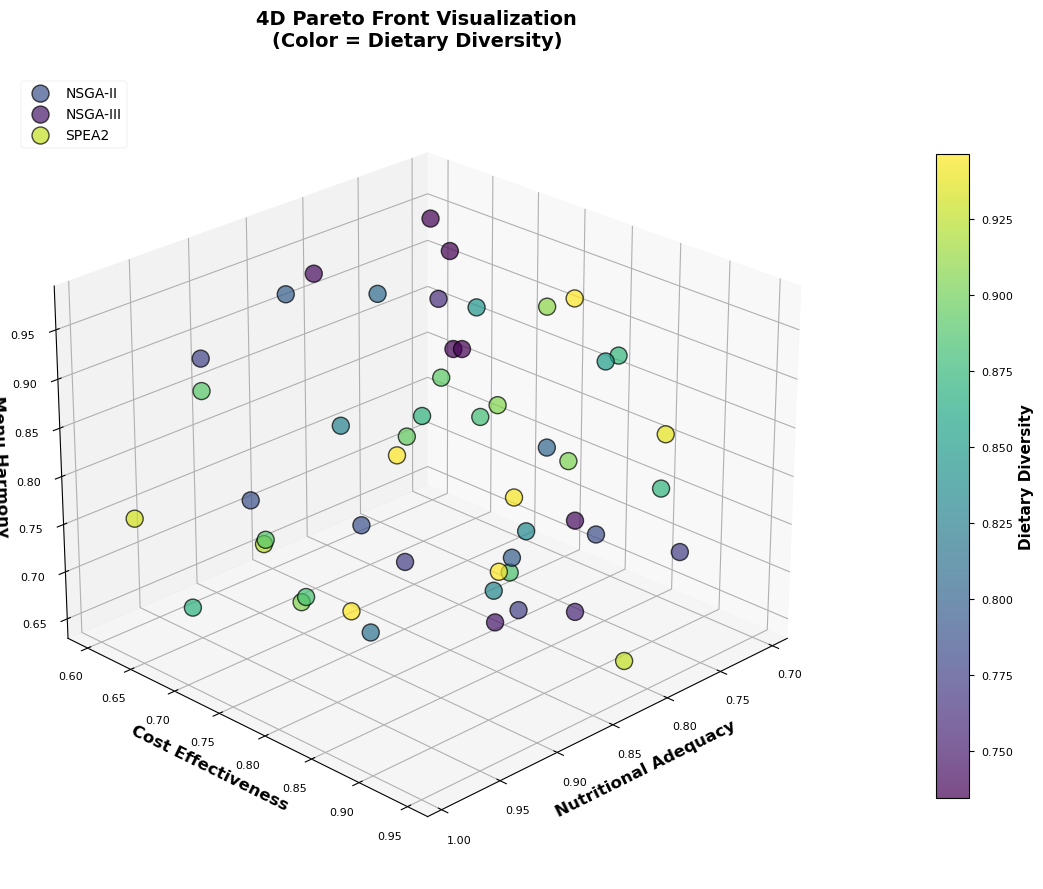

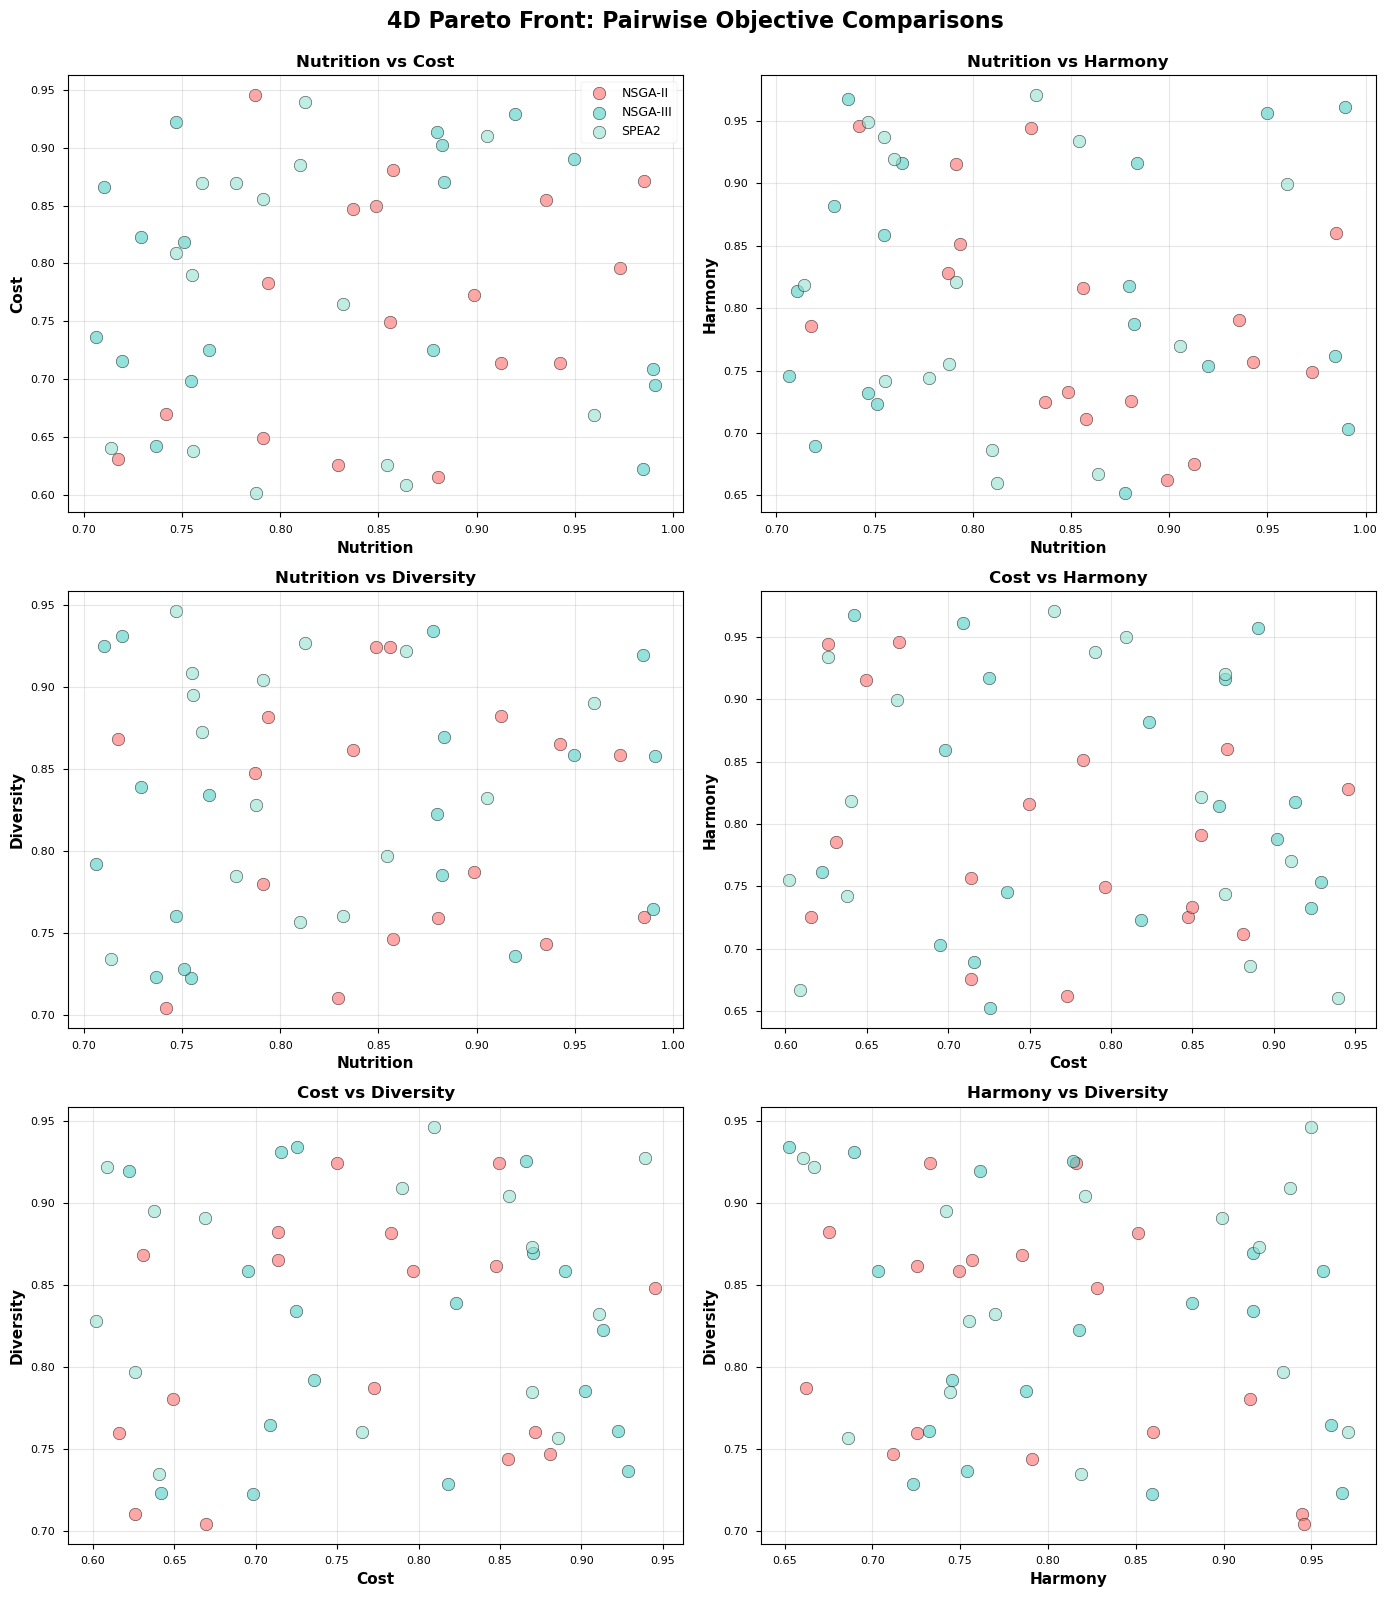

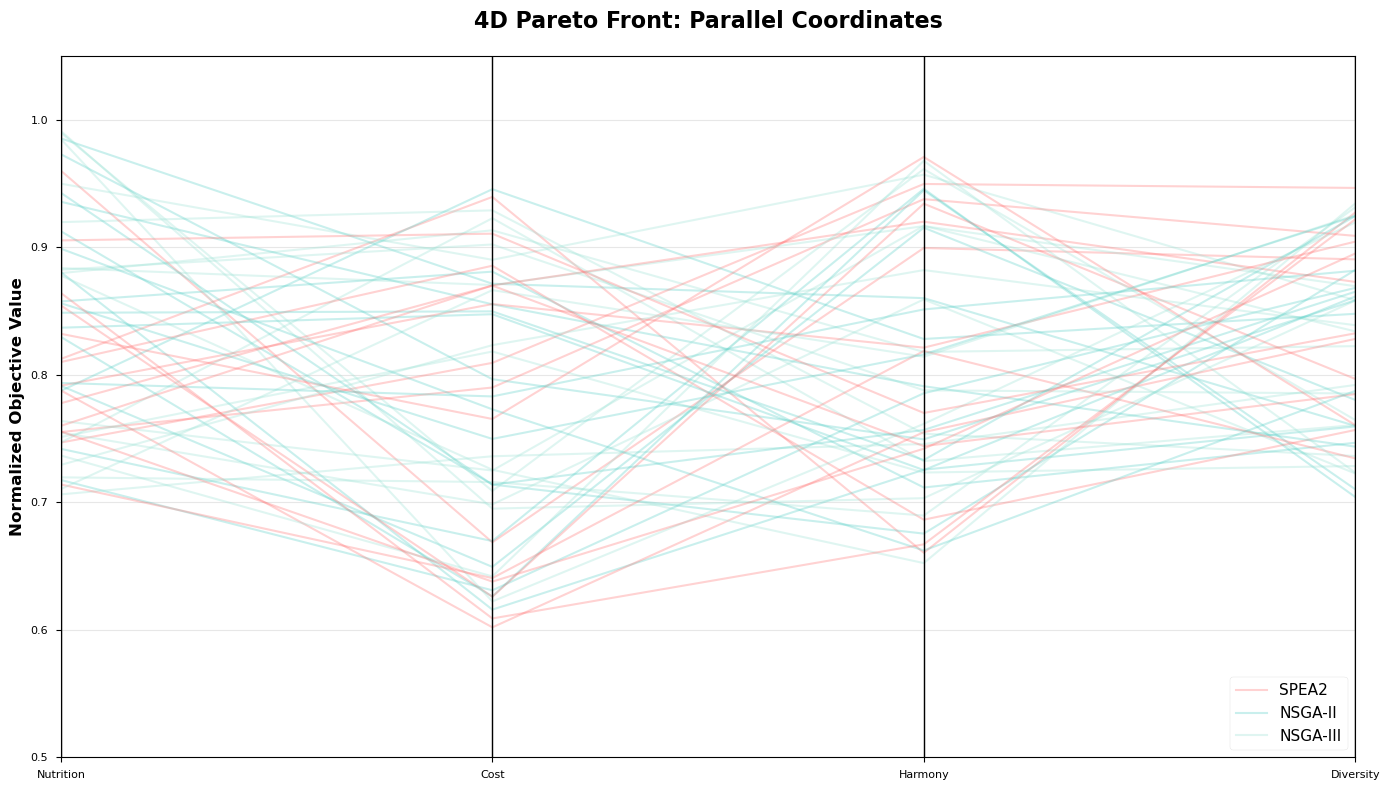

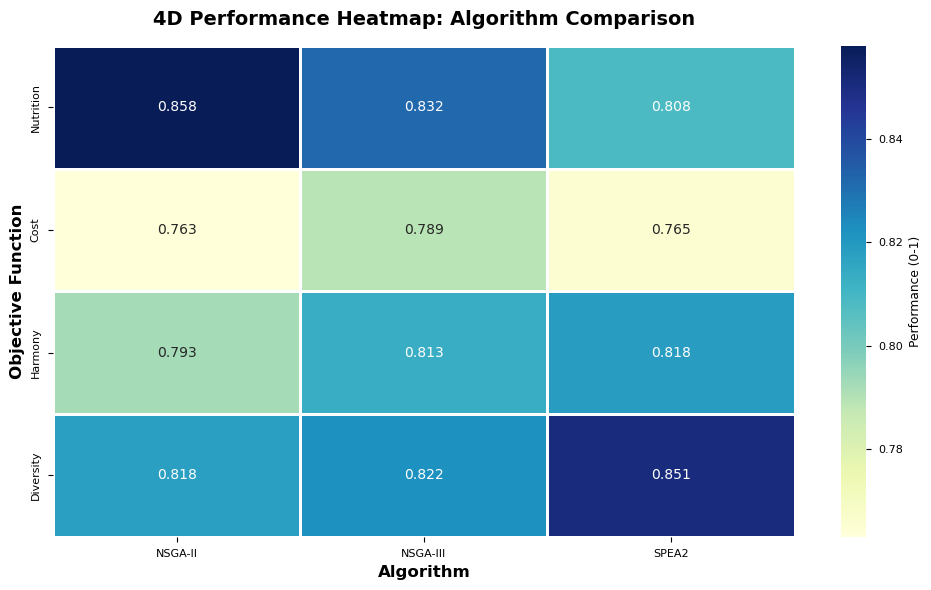

In [16]:
# 샘플 데이터 (실제로는 Pareto Front 해들)
np.random.seed(42)
n_solutions = 50

# 4개 목적함수 (0~1로 정규화된 값)
data = {
    'Nutrition': np.random.uniform(0.7, 1.0, n_solutions),
    'Cost': np.random.uniform(0.6, 0.95, n_solutions),
    'Harmony': np.random.uniform(0.65, 0.98, n_solutions),
    'Diversity': np.random.uniform(0.7, 0.95, n_solutions),
    'Algorithm': np.random.choice(['NSGA-II', 'NSGA-III', 'SPEA2'], n_solutions)
}
df = pd.DataFrame(data)

# ===========================================
# 방법 1: 3D + Color Mapping
# ===========================================
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

for algo, color in zip(['NSGA-II', 'NSGA-III', 'SPEA2'], 
                       ['#FF6B6B', '#4ECDC4', '#95E1D3']):
    mask = df['Algorithm'] == algo
    scatter = ax.scatter(
        df.loc[mask, 'Nutrition'],
        df.loc[mask, 'Cost'],
        df.loc[mask, 'Harmony'],
        c=df.loc[mask, 'Diversity'],  # 4번째 목적함수를 색상으로
        s=150,
        alpha=0.7,
        cmap='viridis',
        edgecolors='black',
        linewidth=1,
        label=algo
    )

ax.set_xlabel('Nutritional Adequacy', fontsize=12, fontweight='bold')
ax.set_ylabel('Cost Effectiveness', fontsize=12, fontweight='bold')
ax.set_zlabel('Menu Harmony', fontsize=12, fontweight='bold')
ax.set_title('4D Pareto Front Visualization\n(Color = Dietary Diversity)', 
             fontsize=14, fontweight='bold', pad=20)

# Colorbar for 4th objective
cbar = plt.colorbar(scatter, ax=ax, pad=0.1, shrink=0.8)
cbar.set_label('Dietary Diversity', fontsize=11, fontweight='bold')

ax.legend(loc='upper left', fontsize=10)
ax.view_init(elev=25, azim=45)

plt.tight_layout()
plt.savefig('../../result/figures/method1_3d_color_mapping.png', dpi=300, bbox_inches='tight')

# ===========================================
# 방법 2: Pairwise Scatter Matrix (2D 조합)
# ===========================================
fig, axes = plt.subplots(3, 2, figsize=(14, 16))
objectives = ['Nutrition', 'Cost', 'Harmony', 'Diversity']
colors_map = {'NSGA-II': '#FF6B6B', 'NSGA-III': '#4ECDC4', 'SPEA2': '#95E1D3'}

pairs = [
    ('Nutrition', 'Cost'),
    ('Nutrition', 'Harmony'),
    ('Nutrition', 'Diversity'),
    ('Cost', 'Harmony'),
    ('Cost', 'Diversity'),
    ('Harmony', 'Diversity')
]

for idx, (obj1, obj2) in enumerate(pairs):
    ax = axes.flat[idx]
    for algo in ['NSGA-II', 'NSGA-III', 'SPEA2']:
        mask = df['Algorithm'] == algo
        ax.scatter(df.loc[mask, obj1], df.loc[mask, obj2], 
                  color=colors_map[algo], label=algo, 
                  s=80, alpha=0.6, edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel(obj1, fontsize=11, fontweight='bold')
    ax.set_ylabel(obj2, fontsize=11, fontweight='bold')
    ax.set_title(f'{obj1} vs {obj2}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    if idx == 0:
        ax.legend(fontsize=9)

plt.suptitle('4D Pareto Front: Pairwise Objective Comparisons', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../../result/figures/method2_pairwise_scatter.png', dpi=300, bbox_inches='tight')

# ===========================================
# 방법 3: Parallel Coordinates Plot
# ===========================================
from pandas.plotting import parallel_coordinates

fig, ax = plt.subplots(figsize=(14, 8))

parallel_coordinates(
    df,
    'Algorithm',
    cols=['Nutrition', 'Cost', 'Harmony', 'Diversity'],
    color=['#FF6B6B', '#4ECDC4', '#95E1D3'],
    alpha=0.3,
    linewidth=1.5,
    ax=ax
)

ax.set_title('4D Pareto Front: Parallel Coordinates', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Normalized Objective Value', fontsize=12, fontweight='bold')
ax.set_ylim([0.5, 1.05])
ax.grid(True, alpha=0.3, axis='y')
ax.legend(loc='lower right', fontsize=11)

plt.tight_layout()
plt.savefig('../../result/figures/method3_parallel_coordinates.png', dpi=300, bbox_inches='tight')

# ===========================================
# 방법 4: Heatmap Matrix (알고리즘 × 목적함수)
# ===========================================
fig, ax = plt.subplots(figsize=(10, 6))

# 알고리즘별 평균 성능
heatmap_data = df.groupby('Algorithm')[objectives].mean()

sns.heatmap(
    heatmap_data.T,  # Transpose for better layout
    annot=True,
    fmt='.3f',
    cmap='YlGnBu',
    cbar_kws={'label': 'Performance (0-1)'},
    linewidths=1,
    linecolor='white',
    ax=ax
)

ax.set_title('4D Performance Heatmap: Algorithm Comparison', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Algorithm', fontsize=12, fontweight='bold')
ax.set_ylabel('Objective Function', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../../result/figures/method4_heatmap_matrix.png', dpi=300, bbox_inches='tight')